In [13]:
from ib_insync import util, IB
import logging

util.startLoop()
util.logToConsole(logging.INFO)

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=0)

2025-05-04 19:03:39,695 ib_insync.client INFO Connecting to 127.0.0.1:7497 with clientId 0...
2025-05-04 19:03:39,697 ib_insync.client INFO Connected
2025-05-04 19:03:39,729 ib_insync.client INFO Logged on to server version 176
2025-05-04 19:03:39,734 ib_insync.client INFO API connection ready
2025-05-04 19:03:39,736 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:usfarm.nj
2025-05-04 19:03:39,737 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:hfarm
2025-05-04 19:03:39,737 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:jfarm
2025-05-04 19:03:39,738 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:usfuture
2025-05-04 19:03:39,738 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
2025-05-04 19:03:39,739 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:eufarmnj
2025-05-04 19:03:39,739 ib

<IB connected to 127.0.0.1:7497 clientId=0>

2025-05-04 19:03:46,982 ib_insync.wrapper ERROR Error 10314, reqId 5: End Date/Time: The date, time, or time-zone entered is invalid. The correct format is yyyymmdd hh:mm:ss xx/xxxx where yyyymmdd and xx/xxxx are optional. E.g.: 20031126 15:59:00 US/Eastern  Note that there is a space between the date and time, and between the time and time-zone.  If no date is specified, current date is assumed. If no time-zone is specified, local time-zone is assumed(deprecated).  You can also provide yyyymmddd-hh:mm:ss time is in UTC. Note that there is a dash between the date and time in UTC notation., contract: Stock(conId=272110, symbol='MSTR', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='MSTR', tradingClass='NMS')
2025-05-04 19:12:04,039 ib_insync.wrapper INFO Warning 2103, reqId -1: Market data farm connection is broken:hfarm
2025-05-04 19:12:04,374 ib_insync.wrapper INFO Warning 2157, reqId -1: Sec-def data farm connection is broken:secdefhk
2025-05-04 19:12:04,376 

In [14]:
from ib_insync import Stock, Contract

# Assume we find the unique stock contract for micro strategy
mstr = Stock('MSTR', 'SMART', 'USD')
assert len(ib.reqContractDetails(mstr)) == 1
ib.qualifyContracts(mstr)
mstr

Stock(conId=272110, symbol='MSTR', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='MSTR', tradingClass='NMS')

In [43]:
import pandas as pd

async def get_historical_data_ib(ib: IB, contract: Contract, duration: str, bar_size: str, what_to_show: str = 'TRADES', use_rth: bool = True, formatDate: str = '1', keepUpToDate: bool = False) -> pd.DataFrame:
    """
    Requests historical market data for a given contract from Interactive Brokers (IB) using ib_insync.

    Args:
        ib (IB): The ib_insync IB client instance.
        contract (Contract): The IB Contract object specifying the security.
        duration (str): The duration string for the historical data request (e.g., '1 Y', '3 M', '1 W', '1 D', '30 D', '1 H', '30 mins').
        bar_size (str): The bar size for the historical data (e.g., '1 secs', '5 secs', '1 min', '5 mins', '1 hour', '1 day').
        what_to_show (str, optional): The type of data to retrieve (e.g., 'TRADES', 'MIDPOINT', 'BID', 'ASK', 'BID_ASK', 'HISTORICAL_VOLATILITY', 'OPTION_IMPLIED_VOLATILITY'). Defaults to 'TRADES'.
        use_rth (bool, optional): Whether to retrieve data only during regular trading hours. Defaults to True.
        formatDate (str, optional): The format of the date in the returned data ('1' for YYYYMMDD HH:MM:SS, '2' for system time in seconds). Defaults to '1'.
        keepUpToDate (bool, optional): If True, the historical data will be updated in real-time. Note: This requires the function to run continuously. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame containing the historical market data with columns:
                          ['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount'].
                          Returns an empty DataFrame if no data is received or if there's an error.
    """
    try:
        bars = await ib.reqHistoricalDataAsync(
            contract,
            endDateTime="20250503 16:00:00 US/Eastern", #set to 20250503 since bitcoin price is downloaded to this date
            durationStr=duration,
            barSizeSetting=bar_size,
            whatToShow=what_to_show,
            useRTH=use_rth,
            formatDate=formatDate,
            keepUpToDate=keepUpToDate
        )
        if bars:
            df = pd.DataFrame([vars(bar) for bar in bars])
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
            return df
        else:
            print(f"No historical data received for {contract.symbol} with duration '{duration}' and bar size '{bar_size}'.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error requesting historical data for {contract.symbol}: {e}")
        return pd.DataFrame()


In [44]:
mstr_his_df = await get_historical_data_ib(ib, mstr, '1 Y', '1 day')
display(mstr_his_df.head())

,date,open,high,low,close,volume,average,barCount
0,2024-05-03,120.10,124.20,117.28,122.30,7287230.0,121.6884,4462
1,2024-05-06,127.39,133.90,126.01,126.88,6284610.0,129.9886,3484
2,2024-05-07,127.82,131.90,125.13,125.75,5174290.0,128.1964,2711
3,2024-05-08,119.84,125.99,119.00,123.31,4130280.0,123.2433,2066
4,2024-05-09,123.00,130.30,120.10,126.36,5199560.0,126.1332,2779


In [45]:
print(mstr_his_df.dtypes)


date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume             float64
average            float64
barCount             int64
dtype: object


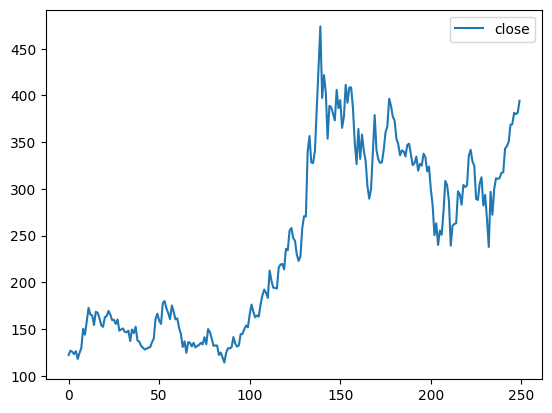

In [46]:
import matplotlib
%matplotlib inline
mstr_his_df.plot(y='close');

In [9]:
ib.reqContractDetails(spot_btc_contract)
# No historical data in account...
spot_btc_contract = Contract(symbol='BTC', secType='CRYPTO', exchange='PAXOS', currency='USD')
btc_his_df = await get_historical_data_ib(ib, spot_btc_contract, '7 D', '1 hour')
display(btc_his_df.head())

ConnectionError: Not connected

## Does not have BTC data from IB

In [47]:
def read_bitcoin_historical_data(csv_filepath):
    try:
        df = pd.read_csv(csv_filepath, parse_dates=['Date'], dayfirst=False)
        return df.sort_values(by='Date', ascending=True).reset_index(drop=True)
    except FileNotFoundError:
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

bitcoin_his_df = read_bitcoin_historical_data("data/nasdaq-bitcoin-5Y-20250503.csv")
print(bitcoin_his_df.dtypes)
display(bitcoin_his_df.head())


Date          datetime64[ns]
Close/Last           float64
Volume               float64
Open                 float64
High                 float64
Low                  float64
dtype: object


,Date,Close/Last,Volume,Open,High,Low
0,2019-03-08,3865.9,NaN,3875.1,3929.0,3810.7
1,2019-03-09,3944.4,NaN,3865.9,3964.0,3859.7
2,2019-03-10,3915.2,NaN,3944.3,3944.5,3889.2
3,2019-03-11,3865.1,NaN,3915.6,3935.5,3842.4
4,2019-03-12,3886.0,NaN,3870.3,3900.1,3817.1


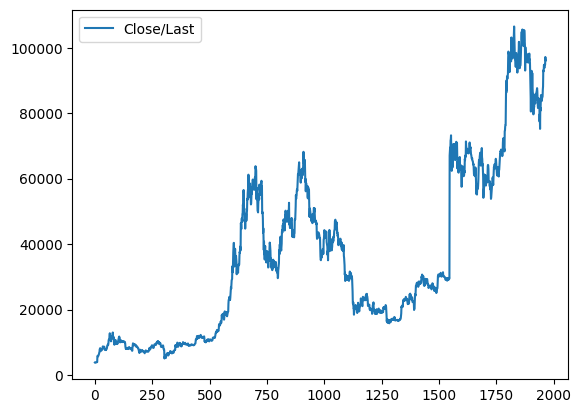

In [41]:
bitcoin_his_df.plot(y='Close/Last');

In [53]:
# bitcoin_his_df = bitcoin_his_df.[(bitcoin_his_df['Date'] >= pd.to_datetime('2024-05-02'))]
mstr_btc_df = pd.merge(mstr_his_df, bitcoin_his_df, left_on='date', right_on='Date', how='left', suffixes=('_mstr', '_btc'))
display(mstr_btc_df.head())

,date,open,high,low,close,volume,average,barCount,Date,Close/Last,Volume,Open,High,Low
0,2024-05-03,120.10,124.20,117.28,122.30,7287230.0,121.6884,4462,2024-05-03,62703.2,NaN,59727.3,63515.4,62599.1
1,2024-05-06,127.39,133.90,126.01,126.88,6284610.0,129.9886,3484,2024-05-06,63238.4,NaN,63875.3,63955.5,62918.3
2,2024-05-07,127.82,131.90,125.13,125.75,5174290.0,128.1964,2711,2024-05-07,62945.3,NaN,63239.5,62950.0,62166.2
3,2024-05-08,119.84,125.99,119.00,123.31,4130280.0,123.2433,2066,2024-05-08,61717.8,NaN,62895.6,61773.6,61152.0
4,2024-05-09,123.00,130.30,120.10,126.36,5199560.0,126.1332,2779,2024-05-09,62864.3,NaN,61678.5,63090.7,62669.2


In [63]:
mstr_btc_df_plot = mstr_btc_df[['date', 'open', 'close', 'Close/Last', 'Open']].rename(columns={'open': 'open_mstr', 'close': 'close_mstr', 'Open': 'open_btc', 'Close/Last':'close_btc'})
mstr_btc_df_plot.head()

,date,open_mstr,close_mstr,close_btc,open_btc
0,2024-05-03,120.10,122.30,62703.2,59727.3
1,2024-05-06,127.39,126.88,63238.4,63875.3
2,2024-05-07,127.82,125.75,62945.3,63239.5
3,2024-05-08,119.84,123.31,61717.8,62895.6
4,2024-05-09,123.00,126.36,62864.3,61678.5


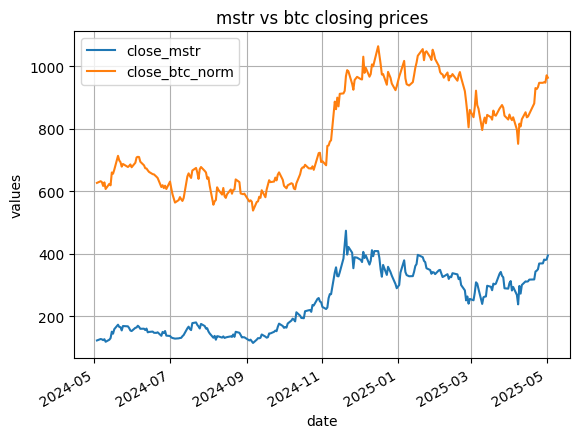

In [64]:
#Normalize BTC price
mstr_btc_df_plot['close_btc_norm'] = mstr_btc_df_plot['close_btc'] / 100
mstr_btc_df_plot.head()

import matplotlib.pyplot as plt

# Plot 'Y1' and 'Y2' against 'X'
mstr_btc_df_plot.plot(x='date', y=['close_mstr', 'close_btc_norm'])
plt.title('mstr vs btc closing prices')
plt.xlabel('date')
plt.ylabel('values')
plt.legend(['close_mstr', 'close_btc_norm'])  # Customize the legend labels
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

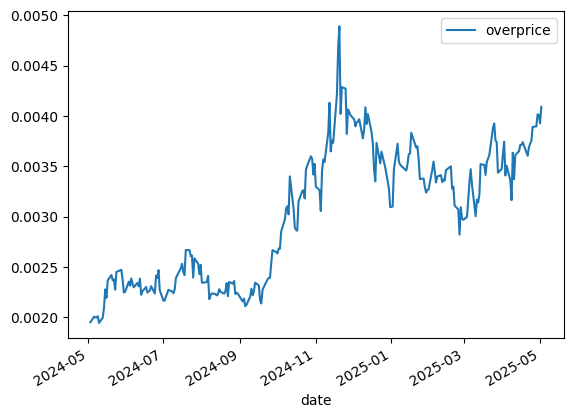

In [65]:
mstr_btc_df_plot['overprice'] = mstr_btc_df_plot['close_mstr']/mstr_btc_df_plot['close_btc']
mstr_btc_df_plot.plot(x='date', y=['overprice'])